In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
from src.utils import *
import pingouin as pg
from scipy import stats
import numpy as np 
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
test_entity = "PY_AR"

connector = Connector(
    json_credentials="/Users/s.lafaurie/.config/gcloud/application_default_credentials.json"
)

significance_runner = SignificanceRunner(
    connector
    , input_table_id= "_dps_ab_test_significance_orders"
    , output_table_id= "test"
)
test_data = significance_runner.import_df(test_entity, dataframe_type="Pandas")

/Users/s.lafaurie/opt/anaconda3/envs/pmsign/lib/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
2023-04-26 07:52:40,040 - INFO - Query ran successfully


Job ID 91a2b505-6dce-4013-9ce0-437fe0a1521b successfully executed: 100%|██████████|
Downloading: 100%|██████████|


In [21]:
class Bootstrapper:
    # TODO -> Add Logger

    """
    The resampler class gather all functionality required to perform a hyphotesis testing by simulation of the 
    H0. 
    For more reference check: https://allendowney.github.io/ElementsOfDataScience/13_hypothesis.html
    """

    def __init__(self, nrg: np.random = np.random.default_rng()) -> None:
        self.nrg = nrg

    def _permutation_test_under_h0(self, control: pd.Series, variation: pd.Series):
        """
        Under H0 -> effect is due to random and there's no difference between control and variation
        combines control and variation data, shuffle it and slice again control and variation.
        """
        n, m = len(control), len(variation)
        data = np.append(control, variation)
        self.nrg.shuffle(data)
        control = data[:n].mean()
        variation = data[n:].mean()
        return variation - control


    def simulate_cont_under_h0(self, control: pd.Series, variation: pd.Series, n_iter = 1000):
        """
        Performs a n_iter number of permutation tests for control and variation
        """
        deltas = []
        for i in tqdm.tqdm(range(n_iter)):
            deltas.append(self._permutation_test_under_h0(control, variation))
        return deltas
    
    def do_h0_test(self, control:pd.Series, variant:pd.Series, n_iter = 2000):
        """
        Performs a n_iter number of permutation tests for control and variation
        """
        # Treatment effect
        test_statistic = variant.mean() - control.mean()

        # simulate under h0
        deltas = self.simulate_cont_under_h0(control, variant, n_iter)
        
        # # test statistics h0
        # diff_of_means_h0 = np.mean(variation_perm, axis=1) - np.mean(control_perm, axis=1)

        # p_sim = (diff_of_means_h0 <= test_statistic).mean()
        # p_val = min([p_sim, 1 - p_sim])
        return test_statistic, deltas
    
bootsrapper = Bootstrapper()

In [6]:
# pandas
test_name = "AR_20230314_R_00_O_AA_Test_MDQ_v2"
treatment = "All"
metric = "delivery_distance"
single_test_data = significance_runner.filter_dataframe_for_metric(test_data, test_name, treatment, metric)
control, variant = significance_runner.split_dataset_into_variants(single_test_data, metric, TestConstants.CONTROL, TestConstants.VARIATION1)
# effect, deltas = bootsrapper.do_h0_test(control, variant)


In [15]:

combined = np.append(control, variant)
B = 5000
t = variant.mean() - control.mean()

t_bootstrap = []
sample_means = []
stat = []
for i in tqdm.tqdm(range(B)):
    perm = np.random.choice(combined, size=len(combined), replace=True)
    control_perm =  perm[:len(control)]
    variation_perm = perm[len(control):]

    #
    control_perm_mean = control_perm.mean()
    variation_perm_mean = variation_perm.mean()
    sample_means.append((control_perm, variation_perm))

    # bootstrap statistic
    t_miu = variation_perm_mean - control_perm_mean
    t_bootstrap.append(t_miu)

    # comparison
    stat.append(abs(t_miu) >= abs(t))


100%|██████████| 5000/5000 [00:21<00:00, 236.20it/s]


In [23]:
deltas, effect = bootsrapper.do_h0_test(control, variant, 5000)


100%|██████████| 5000/5000 [00:17<00:00, 284.90it/s]


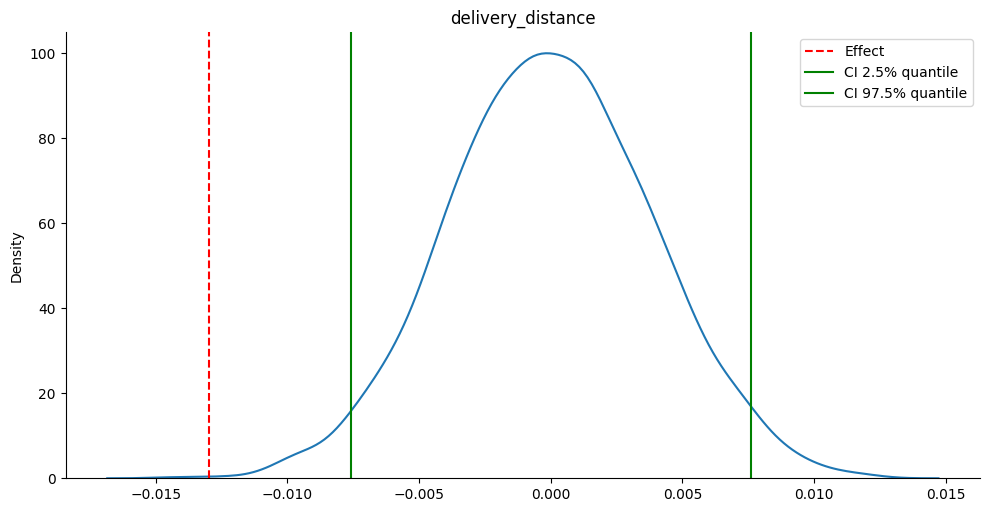

In [31]:



ql, qr = np.quantile(t_bootstrap, [0.025, 0.975])
# plt.figure(figsize=(30, 10))
sns.displot(t_bootstrap, aspect=2, kind='kde')
plt.title(f'{metric}')
plt.axvline(t, label='Effect', color='r', linestyle='--')
plt.axvline(ql, label='CI 2.5% quantile', color='g', linestyle='-')
plt.axvline(qr, label='CI 97.5% quantile', color='g', linestyle='-')

plt.legend()